# Multimodal RAG

### We are setting up a RAG chatbot after pulling data from your favourite fandom page.

This notebook contains setup, ingestion, advanced chunking strategies, embeddings & indexing, advanced retrieval (MMR), query decomposition, and a Gradio chat UI demonstrating retrieval-augmented generation with visual grounding patterns.

Prerequisite - Colab PRO<br>

https://support.google.com/googleone/answer/16417758?hl=en#:~:text=If%20you're%20a%20student,and%20how%20to%20sign%20up.

**Run cells in order.** Designed for Google Colab (GPU A100recommended).

## 0 — Background

#### 0.1 — Large Language Models

 - Trained to predict next token.
 - Modern chat interfaces have other tools like websearch, code compiler, calculator etc to get the best result.

https://www.youtube.com/watch?v=zjkBMFhNj_g&t=2004s


#### 0.2 — RAG - Retrieval Augmented Generation

 *You would have used it, without knowing it.*


 Have used any AI models to generate questions based on your lecture ppt/ Resume/ Job description?

 - Prompting with your private data as context.


  https://notebooklm.google/



#### 0.3 — RAG - Steps in RAG

##### RAG – Embedding Generation Steps (For your data)

- Load documents (PDF, TXT, MD, etc.)
- Chunk text
- Generate embeddings for each chunk
- Store embedding in vector db

##### RAG – Prompting Step (While you are prompting)
 - User asks a questionInput
 - Query Embedding Convert the question into a vector using an embedding model
 - Search Private Knowledge BaseUse vector database
 - Retrieve Relevant ContextOutput
 - Build Augmented PromptCombine






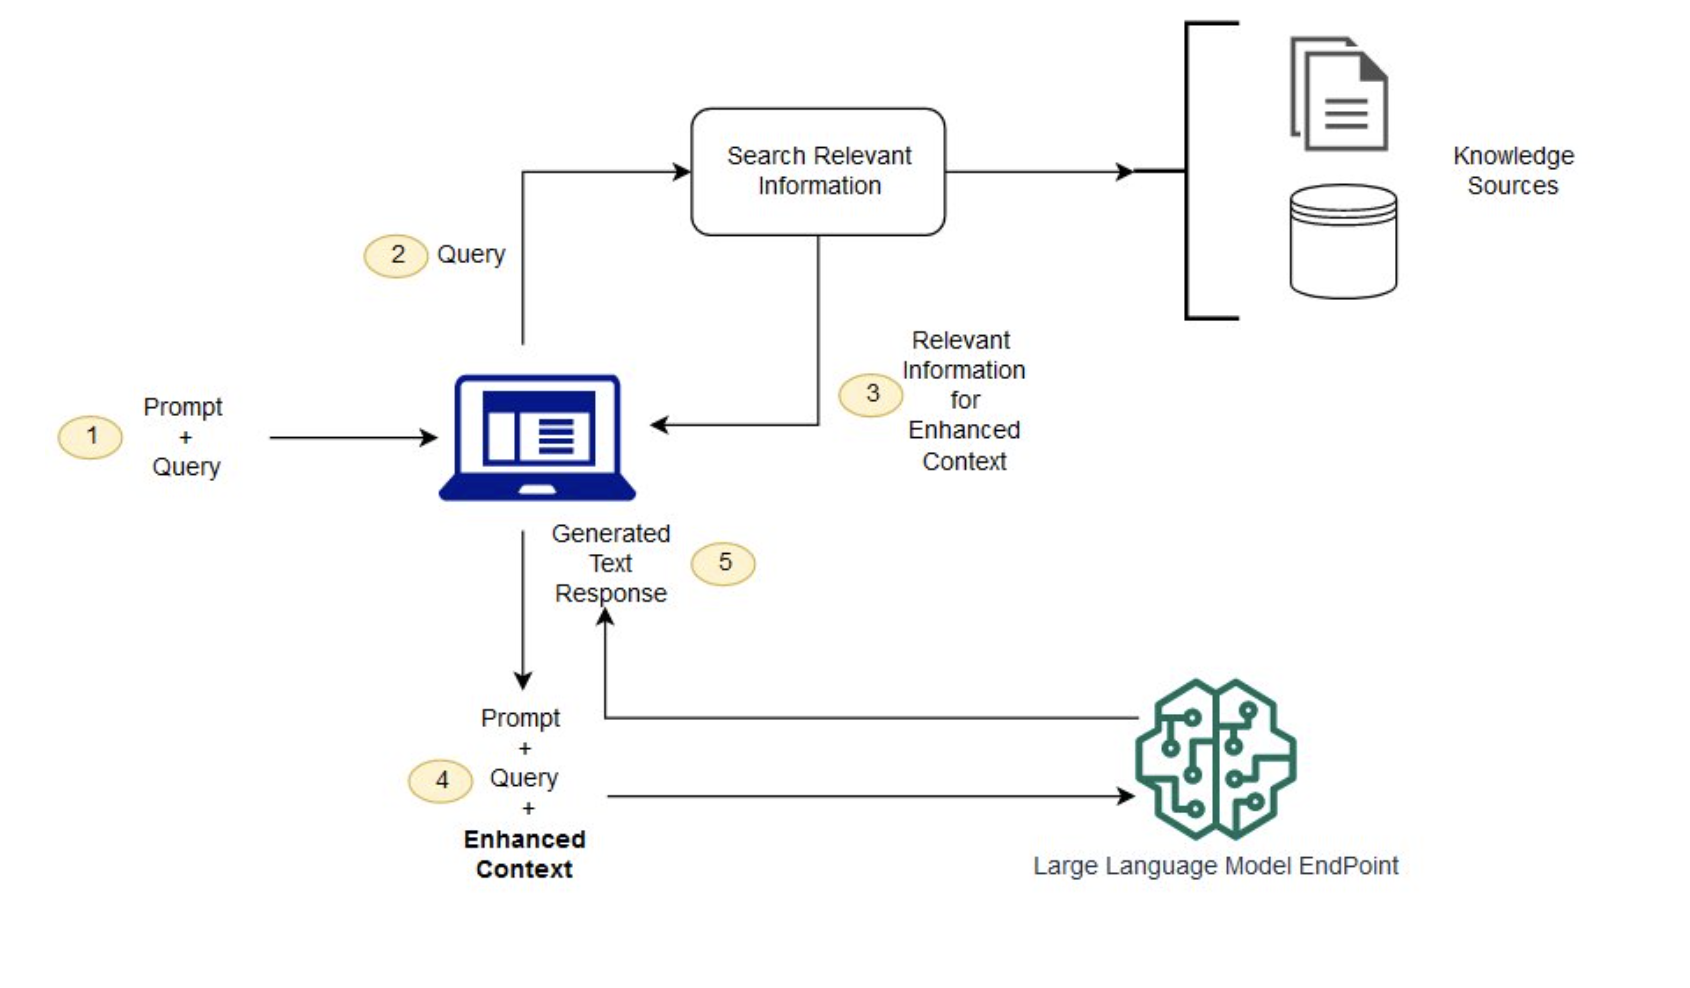

#### 0.3 — Multi Modal RAG

Multimodal RAG integrates text, images, and other data types into retrieval-augmented generation for richer, context-aware responses.

*Generates Embeddings for both text and Image*


#### 0.4 — In this NoteBook

- Pull data from you favourite fandom Wiki Page
    - Crawl the Fandom Page
    - Pull Text and Images.
- Cleans and Chunks the crawled data
- Generate Embeddings
- Using Opensource Models from huggingFace
- Retrieve embedding with similarity search
- Query decomposition for bigger Queries
- Gradio UI for chat Interface

The following models are used in this notebook:

*   **`SentenceTransformer("clip-ViT-B-32")`**: This model is used for generating embeddings for both text and images, enabling multimodal search.
*   **`BlipProcessor` and `BlipForConditionalGeneration`**: These are used for generating captions for images.
*   **`mistralai/Mistral-7B-Instruct-v0.2` (with fallback to `google/flan-t5-base` or `facebook/opt-125m`)**: This model is used for decomposing complex questions into sub-questions and for synthesizing the final answer from retrieved information.
* **ChromaDB** as vector Database

#### Disclaimer

- Models we are using are small (1.8T vs 7B)

##### Enviornment Check
Prerequisite - Colab PRO<br>

https://support.google.com/googleone/answer/16417758?hl=en#:~:text=If%20you're%20a%20student,and%20how%20to%20sign%20up. <br>

https://colab.research.google.com/signup<br>

Hugging Face APi - TBD

## 1 — Install dependencies



In [ ]:
# Install necessary libraries for the multimodal RAG notebook
!pip install -q langchain llama-index chromadb qdrant-client sentence-transformers unstructured pymupdf pytesseract layoutparser gradio transformers accelerate safetensors faiss-cpu torch  langchain-community

# Run this cell again if there is some error
print('Install step finished.')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 45.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 123.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.3/337.3 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 102.8 MB

### 1.a Dependencies
1. langchain: A framework for developing applications powered by language models.
2. llama-index: A data framework for LLM applications, providing data connectors and indexing strategies.
3. chromadb: An open-source embedding database for building AI applications with embeddings.
4. qdrant-client: A vector similarity search engine and vector database client.
5. sentence-transformers: A Python framework for state-of-the-art sentence, text, and image embeddings.
6. unstructured: A library for parsing and cleaning unstructured data like PDFs and images.
7. pymupdf: A Python binding for MuPDF, a lightweight PDF, XPS, and eBook renderer.
8. pytesseract: A Python wrapper for Google's Tesseract-OCR Engine, used for optical character recognition.
9. layoutparser: A unified toolkit for document image analysis.
10. gradio: A library for building customizable UI demos for machine learning models.
11. transformers: A library providing thousands of pre-trained models to perform tasks on texts, images, audio, and more.
12. accelerate: A library for accelerating PyTorch training on various hardware setups.
13. safetensors: A new simple format for storing tensors, safer than pickle.
14. faiss-cpu: A library for efficient similarity search and clustering of dense vectors on CPU.

## 2 — Verify runtime & GPU

In [ ]:
# Import required libraries to verify their versions and CUDA availability
import torch, transformers, sentence_transformers, gradio

# Print the installed version of PyTorch
print('Torch:', torch.__version__)
# Check and print if CUDA is available for GPU acceleration
print('CUDA available:', torch.cuda.is_available())
# If CUDA is available, print the name of the CUDA device being used
if torch.cuda.is_available():
    print('Device:', torch.cuda.get_device_name(0))
# Print the installed version of the transformers library
print('transformers:', transformers.__version__)
# Print the installed version of the sentence-transformers library
print('sentence-transformers:', sentence_transformers.__version__)
# Print the installed version of the gradio library
print('gradio:', gradio.__version__)

Torch: 2.8.0+cu126
CUDA available: True
Device: NVIDIA A100-SXM4-80GB
transformers: 4.57.1
sentence-transformers: 5.1.2
gradio: 5.49.1


## 3 - Data Ingestion via crawling

Source Website - https://www.fandom.com/ <br>
*Note : For the sake of time we can use, wiki where page count is less than 200*

In [ ]:
# Import the requests library for making HTTP requests (used for crawling the wiki)
import requests
# Import the os module for interacting with the operating system (used for creating directories)
import os
# Import the quote function from urllib.parse to URL-encode page titles
from urllib.parse import quote
# Import the Path class from pathlib for working with filesystem paths (not directly used in this snippet but often used with os)
from pathlib import Path
# Import BeautifulSoup from bs4 for parsing HTML content
from bs4 import BeautifulSoup

**IT CROWD**<br>
https://www.youtube.com/watch?v=MwwTfkXk7U0<br>
https://theitcrowd.fandom.com/wiki/The_IT_Crowd_Wiki


*Fandom API documentation* - https://dev.fandom.com/wiki/Dev_Wiki:Sandbox/API

In [ ]:
# Define the base URL for the Fandom API for 'theitcrowd' wiki
WIKI = "theitcrowd" # Make Sure this is the exact page as it is a string parsing.
API_ROOT = f"https://{WIKI}.fandom.com/api.php"

# Function to get all page titles from the specified Fandom wiki using the API
def get_all_pages(batch_size=500):
    pages = [] # Initialize an empty list to store page titles
    apcontinue = None # Initialize the continue parameter for pagination
    while True:
        # Define parameters for the API request to list all pages ('allpages')
        params = {
            "action": "query",
            "list": "allpages",
            "aplimit": batch_size, # Limit the number of results per batch
            "format": "json", # Request the response in JSON format
        }
        # Add the 'apcontinue' parameter to the request if it exists (for pagination)
        if apcontinue:
            params["apcontinue"] = apcontinue
        # Make a GET request to the Fandom API with the defined parameters
        resp = requests.get(API_ROOT, params=params)
        # Raise an exception if the request returned a bad status code (e.g., 404, 500)
        resp.raise_for_status()
        # Parse the JSON response from the API
        data = resp.json()
        # Extract page titles from the 'allpages' list in the JSON response
        for p in data["query"]["allpages"]:
            pages.append(p["title"])
        # Check if there is a 'continue' key in the response, indicating more pages
        if "continue" in data:
            # Get the value of 'apcontinue' from the 'continue' object for the next iteration
            apcontinue = data["continue"]["apcontinue"]["apcontinue"] # Corrected key access
        else:
            break # If no 'continue' key, all pages have been retrieved, so break the loop
    return pages # Return the list of all page titles

In [ ]:
# Function to get the content and images associated with a specific page title from the Fandom wiki
def get_page_content_and_images(title):
    # Define parameters for the API request to parse a page ('parse') and get text and images ('prop')
    params = {
        "action": "parse",
        "page": title, # Specify the title of the page to parse
        "prop": "text|images", # Request the page's text (as HTML) and a list of images
        "format": "json" # Request the response in JSON format
    }
    # Make a GET request to the Fandom API with the defined parameters
    resp = requests.get(API_ROOT, params=params)
    # Raise an exception for bad status codes
    resp.raise_for_status()
    # Parse the JSON response and get the 'parse' object
    data = resp.json()["parse"]
    # Extract the HTML text content of the page
    html = data["text"]["*"]
    # Extract the list of image names from the response (defaults to empty list if no images)
    images = data.get("images", [])
    # Use BeautifulSoup to parse the HTML content
    soup = BeautifulSoup(html, "html.parser")
    # Extract plain text from the HTML, using a newline as a separator between elements
    text = soup.get_text(separator="\n")
    # Return the plain text, the list of image names, and the original HTML
    return text, images, html

In [ ]:
# Function to download an image from the Fandom wiki given its name
def download_image(image_name, outdir="images"):
    # Define parameters for the API request to get information about an image file ('File:image_name')
    params = {
        "action": "query",
        "titles": "File:" + image_name, # Specify the image file title (prefixed with "File:")
        "prop": "imageinfo", # Request image information
        "iiprop": "url", # Request the URL of the image file
        "format": "json" # Request the response in JSON format
    }
    # Make a GET request to the Fandom API
    resp = requests.get(API_ROOT, params=params)
    # Raise an exception for bad status codes
    resp.raise_for_status()
    # Parse the JSON response and get the 'pages' object
    pages = resp.json()["query"]["pages"]
    # Iterate through the pages (should be only one for a specific file title)
    for p in pages.values():
        # Check if 'imageinfo' is present in the page information
        if "imageinfo" in p:
            # Extract the image URL from the 'imageinfo' list
            url = p["imageinfo"][0]["url"]
            # Define the local filename for the downloaded image, replacing '/' with '_' in the image name
            fname = os.path.join(outdir, image_name.replace("/", "_"))
            # Create the output directory if it doesn't exist
            os.makedirs(outdir, exist_ok=True)
            # Download the image from the URL using a streaming request
            with requests.get(url, stream=True) as r:
                # Raise an exception for bad status codes
                r.raise_for_status()
                # Open the local file in binary write mode
                with open(fname, "wb") as f:
                    # Iterate over the content in chunks and write to the file
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)
            return fname # Return the local path of the downloaded image
    return None # Return None if image information or URL was not found

In [ ]:
# Call the get_all_pages function to retrieve all page titles from the wiki
# Limit the batch size to 200 per API request
pages = get_all_pages(batch_size=200)
# Print the total number of pages found
print("Found pages:", len(pages))

Found pages: 193


In [ ]:
# Initialize an empty list to store the processed documents
docs = []
# Set a limit on the number of pages to crawl to avoid excessive processing
LIMIT = 200 #limiting how pages to crawl
# Iterate through the first 'LIMIT' number of page titles
for title in pages[: LIMIT]:
    # Get the text content, image names, and HTML for the current page
    text, images, html = get_page_content_and_images(title)
    image_files = [] # Initialize an empty list to store paths of downloaded images
    # Iterate through the list of image names found on the page
    for img_name in images:
        try:
            # Attempt to download each image
            fpath = download_image(img_name, outdir="images")
            # If the image was successfully downloaded, add its path to the list
            if fpath:
                image_files.append(fpath)
        except Exception as e:
            # Print an error message if downloading an image fails
            print("Failed to download image", img_name, e)
    # Append a dictionary representing the processed document to the 'docs' list
    docs.append({
        "title": title, # The title of the wiki page
        "text": text, # The raw text content of the page
        "images": image_files, # The list of local paths to downloaded images
        "metadata": { # Metadata associated with the document
            "source": f"https://{WIKI}.fandom.com/wiki/{quote(title)}", # The source URL of the page
            "WIKI": WIKI # The name of the wiki
            }
    })

# Print the total number of documents collected after crawling
print("Collected docs:", len(docs))

Collected docs: 193


In [ ]:
# Display the first document in the 'docs' list to inspect its structure and content
docs[0]

{'title': '0118 999 881 999 119 7253',
 'text': "0118 999 881 999 119 725 3\n is the number of the 'New and Improved' emergency services, replacing the old \n999\n. The 'New and Improved' emergency services promise nicer ambulances, faster response times and better-looking drivers. The number is shown with a catchy jingle, which Moss easily memorizes. While Moss remembers this, he tried to call it in event of a fire, which got him through to another country, resorting to a formal email instead.\n\n\n\n\n\n\n\n\n",
 'images': [],
 'metadata': {'source': 'https://theitcrowd.fandom.com/wiki/0118%20999%20881%20999%20119%207253',
  'WIKI': 'theitcrowd'}}

In [ ]:
# Check if any documents in the first 50 have associated images
# Iterate through the first 50 documents (or fewer if less than 50 docs)
for i in range (0,min(50, len(docs))):
  # Check if the current document has any images in its 'images' list
  if(len(docs[i]['images'])>0):
    # If images are present, print the title of the page
    print(docs[i]['title'])
    # Print the source URL of the page
    print(docs[i]['metadata']['source'])

Andie Vining
https://theitcrowd.fandom.com/wiki/Andie%20Vining
Are We Not Men?
https://theitcrowd.fandom.com/wiki/Are%20We%20Not%20Men%3F
Aunt Irma Visits
https://theitcrowd.fandom.com/wiki/Aunt%20Irma%20Visits
Bad Boys
https://theitcrowd.fandom.com/wiki/Bad%20Boys
BluffBall.co.uk
https://theitcrowd.fandom.com/wiki/BluffBall.co.uk
Calamity Jen
https://theitcrowd.fandom.com/wiki/Calamity%20Jen
Calendar Geeks
https://theitcrowd.fandom.com/wiki/Calendar%20Geeks
Chris (dating site member)
https://theitcrowd.fandom.com/wiki/Chris%20%28dating%20site%20member%29
Chris (disambiguation)
https://theitcrowd.fandom.com/wiki/Chris%20%28disambiguation%29
Chris Morris
https://theitcrowd.fandom.com/wiki/Chris%20Morris
Chris O'Dowd
https://theitcrowd.fandom.com/wiki/Chris%20O%27Dowd
Daniel Carey
https://theitcrowd.fandom.com/wiki/Daniel%20Carey
Denholm Reynholm
https://theitcrowd.fandom.com/wiki/Denholm%20Reynholm
Denholm Reynholm's mother
https://theitcrowd.fandom.com/wiki/Denholm%20Reynholm%27s%20mot

## 4 - Cleaning and chunking Data

Chunking strategies - https://www.reddit.com/r/Rag/comments/1gcf39v/comparative_analysis_of_chunking_strategies_which/#lightbox <br>
Cleaning Crawled Data - https://webcrawlerapi.com/blog/clean-crawled-data-with-beautifulsoup-in-python

In [ ]:
# Import the regular expression module for text cleaning
import re
# Import BeautifulSoup from bs4 for parsing HTML content
from bs4 import BeautifulSoup

In [ ]:
# Function to clean raw wiki HTML text
def clean_wiki_text(raw_html):
    # Parse the HTML using BeautifulSoup
    soup = BeautifulSoup(raw_html, "html.parser")
    # Get plain text from the HTML, using a newline as a separator
    text = soup.get_text(separator="\n")
    # Remove references like [edit], [1], etc. using regular expressions
    text = re.sub(r"\[\d+\]", "", text)
    # Replace multiple whitespace characters with a single space
    text = re.sub(r"\s+", " ", text)
    # Remove leading and trailing whitespace
    return text.strip()

# Apply the cleaning function to the 'text' field of each document in the 'docs' list
# Store the cleaned text in a new key called 'clean_text'
for d in docs:
    d["clean_text"] = clean_wiki_text(d["text"])

In [ ]:
# Print the first 1000 characters of the cleaned text of the first document
# This helps to inspect the result of the text cleaning process
print(docs[0]["clean_text"][:1000])

0118 999 881 999 119 725 3 is the number of the 'New and Improved' emergency services, replacing the old 999 . The 'New and Improved' emergency services promise nicer ambulances, faster response times and better-looking drivers. The number is shown with a catchy jingle, which Moss easily memorizes. While Moss remembers this, he tried to call it in event of a fire, which got him through to another country, resorting to a formal email instead.


In [ ]:
# Import the RecursiveCharacterTextSplitter from langchain for text splitting
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Initialize the splitter with a chunk size of 250 characters and an overlap of 100 characters
# Chunking breaks down large texts into smaller, manageable pieces
splitter = RecursiveCharacterTextSplitter(chunk_size=250, chunk_overlap=100)

In [ ]:
splitter.split_text(docs[0]["clean_text"])

["0118 999 881 999 119 725 3 is the number of the 'New and Improved' emergency services, replacing the old 999 . The 'New and Improved' emergency services promise nicer ambulances, faster response times and better-looking drivers. The number is shown",
 'promise nicer ambulances, faster response times and better-looking drivers. The number is shown with a catchy jingle, which Moss easily memorizes. While Moss remembers this, he tried to call it in event of a fire, which got him through to another',
 'While Moss remembers this, he tried to call it in event of a fire, which got him through to another country, resorting to a formal email instead.']

In [ ]:
# Import the uuid module to generate unique identifiers
import uuid

# Initialize an empty list to store the expanded documents (text chunks)
expanded_docs = []
# Iterate through each document in the original 'docs' list
for d in docs:
    # Split the 'clean_text' of the current document into chunks using the defined splitter
    for i, chunk in enumerate(splitter.split_text(d["clean_text"])):
        # Append a new dictionary for each chunk to the 'expanded_docs' list
        expanded_docs.append({
            "id": str(uuid.uuid4()), # Assign a unique ID using UUID
            "text": chunk, # The text content of the chunk
            "metadata": {"source": d["metadata"]["source"], "title": d["title"], "chunk": i} # Metadata including source, title, and chunk index
        })

In [ ]:
expanded_docs[:5]

[{'id': '8df04e7b-2500-44ce-94ff-5d46d4a906c8',
  'text': "0118 999 881 999 119 725 3 is the number of the 'New and Improved' emergency services, replacing the old 999 . The 'New and Improved' emergency services promise nicer ambulances, faster response times and better-looking drivers. The number is shown",
  'metadata': {'source': 'https://theitcrowd.fandom.com/wiki/0118%20999%20881%20999%20119%207253',
   'title': '0118 999 881 999 119 7253',
   'chunk': 0}},
 {'id': '74fe5064-c7d6-4004-af8b-f1c3407e891f',
  'text': 'promise nicer ambulances, faster response times and better-looking drivers. The number is shown with a catchy jingle, which Moss easily memorizes. While Moss remembers this, he tried to call it in event of a fire, which got him through to another',
  'metadata': {'source': 'https://theitcrowd.fandom.com/wiki/0118%20999%20881%20999%20119%207253',
   'title': '0118 999 881 999 119 7253',
   'chunk': 1}},
 {'id': '250e8155-16c2-49f7-9a1b-43ca1eb7279b',
  'text': 'While Mos

##### 4.a Simple OCR for diagrams and screenshots

Tesseract - https://github.com/tesseract-ocr/tesseract?tab=readme-ov-file#about

In [ ]:
# Import the Image class from the PIL (Pillow) library for image manipulation
from PIL import Image
# Import the pytesseract library for performing Optical Character Recognition (OCR)
import pytesseract

# Function to perform OCR on an image file
def ocr_image(path):
    try:
        # Open the image file and perform OCR to extract text
        text = pytesseract.image_to_string(Image.open(path))
        # Return the extracted text, removing leading/trailing whitespace
        return text.strip()
    except Exception as e:
        # Print an error message if OCR fails for a specific image
        print("OCR failed:", path, e)
        return "" # Return an empty string if OCR fails

# Initialize an empty list to store documents created from images
image_docs = []
# Iterate through each document in the original 'docs' list
for d in docs:
    # Iterate through the list of image paths associated with the current document
    for img_path in d["images"]:
        # Append a dictionary for each image to the 'image_docs' list
        image_docs.append({
            "id": img_path, # Use the image path as the ID
            "text": ocr_image(img_path),  # Perform OCR on the image and store the result as text
            "metadata": {"source": d["metadata"]["source"], "page": d["title"], "image_path": img_path} # Metadata including source, page title, and image path
        })

In [ ]:
# Iterate through the 'image_docs' list
for image in image_docs:
  # Check if the 'text' field (OCR result) of the current image document is not empty
  if(image['text']!=""):
    # If the text is not empty, print the image document dictionary
    # This shows which images had successful OCR results with extracted text
    print(image)

{'id': 'images/BluffB.png', 'text': 'Ma ee eg -Y Ve meats\nXu\n\n7 es', 'metadata': {'source': 'https://theitcrowd.fandom.com/wiki/BluffBall.co.uk', 'page': 'BluffBall.co.uk', 'image_path': 'images/BluffB.png'}}
{'id': 'images/Friendfacelogo.png', 'text': 'Friendface', 'metadata': {'source': 'https://theitcrowd.fandom.com/wiki/Friendface.com', 'page': 'Friendface.com', 'image_path': 'images/Friendfacelogo.png'}}
{'id': 'images/FriendFaceBlocked.gif', 'text': 'B2P6N.03. SPEAR F238\n\nCy\nCa tT:\n\nDear value employee,', 'metadata': {'source': 'https://theitcrowd.fandom.com/wiki/Friendface.com', 'page': 'Friendface.com', 'image_path': 'images/FriendFaceBlocked.gif'}}
{'id': 'images/Homomusical.png', 'text': 'PEBROOK PRODUCTIONS\n\n7a\n\n4 gay musical', 'metadata': {'source': 'https://theitcrowd.fandom.com/wiki/Gay%21%20A%20Gay%20Musical', 'page': 'Gay! A Gay Musical', 'image_path': 'images/Homomusical.png'}}
{'id': 'images/S05E01-GBV_Jen.jpg', 'text': 'GUIDED BY VOICES ,', 'metadata': {'

##### 4.b Auto caption generation (BLIP-2 / Florence)

Now we are going to use our first large language model <br>

We need HuggingFace API Key
https://www.geeksforgeeks.org/artificial-intelligence/how-to-access-huggingface-api-key/

In [ ]:
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')

In [ ]:
from huggingface_hub import login
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")

Successfully logged in to Hugging Face!


##### Salesforce/blip-image-captioning-base
https://huggingface.co/Salesforce/blip-image-captioning-base

In [ ]:
# Import necessary classes from transformers for image captioning (BLIP model)
from transformers import BlipProcessor, BlipForConditionalGeneration
# Import Image from PIL for image handling
from PIL import Image
# Import torch for using CUDA if available
import torch

# Load the processor for the BLIP image captioning model
# The processor prepares the image data for the model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
# Load the BLIP model itself and move it to the appropriate device (GPU if available, otherwise CPU)
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda" if torch.cuda.is_available() else "cpu")

# Function to generate a caption for a given image file path
def caption_image(image_path):
    # Open the image file and convert it to RGB format (required by the model)
    image = Image.open(image_path).convert("RGB")
    # Process the image and prepare it as input tensors for the model, moving to the correct device
    inputs = processor(image, return_tensors="pt").to(model.device)
    # Generate the caption using the loaded BLIP model
    # max_new_tokens limits the length of the generated caption
    out = model.generate(**inputs, max_new_tokens=30)
    # Decode the generated token IDs back into a human-readable string
    # skip_special_tokens=True removes special tokens like [CLS], [SEP], etc.
    return processor.decode(out[0], skip_special_tokens=True)

# Initialize an empty list to store documents representing image captions
image_caption_docs = []
# Iterate through each document in the original 'docs' list
for d in docs:
    # Iterate through the image paths associated with the current document
    for img_path in d["images"]:
        # Generate a caption for the current image
        caption = caption_image(img_path)
        # Append a dictionary for the image caption document
        image_caption_docs.append({
            "id": img_path, # Use the image path as the document ID
            "text": caption, # The generated caption as the document text
            "metadata": {"source": d["metadata"]["source"], "page": d["title"], "image_path": img_path} # Metadata including source URL, page title, and image path
        })

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
for image in image_caption_docs:
  if(image['text']!=""):
    print(image)

{'id': 'images/AndieVining.png', 'text': 'a picture of a man with a hat on', 'metadata': {'source': 'https://theitcrowd.fandom.com/wiki/Andie%20Vining', 'page': 'Andie Vining', 'image_path': 'images/AndieVining.png'}}
{'id': 'images/Postman.png', 'text': 'a man in a tie', 'metadata': {'source': 'https://theitcrowd.fandom.com/wiki/Are%20We%20Not%20Men%3F', 'page': 'Are We Not Men?', 'image_path': 'images/Postman.png'}}
{'id': 'images/Ladyproblems.jpg', 'text': 'a man and woman standing next to each other people', 'metadata': {'source': 'https://theitcrowd.fandom.com/wiki/Aunt%20Irma%20Visits', 'page': 'Aunt Irma Visits', 'image_path': 'images/Ladyproblems.jpg'}}
{'id': 'images/Team.png', 'text': 'a man in a suit and tie standing next to a painting of a woman', 'metadata': {'source': 'https://theitcrowd.fandom.com/wiki/Bad%20Boys', 'page': 'Bad Boys', 'image_path': 'images/Team.png'}}
{'id': 'images/BluffB.png', 'text': 'buffalo buffalo buffalo buffalo buffalo buffalo buffalo buffalo buf

In [ ]:
# Combine the list of text chunks ('expanded_docs') and the list of image documents ('image_caption_docs')
# This creates a single list containing all documents (text and image-based) for indexing
all_docs = expanded_docs + image_caption_docs  #+ image_docs

In [ ]:
# Print the total number of documents in the combined list ('all_docs')
print("Total length",len(all_docs))

Total length 3957


In [ ]:
all_docs[0]

{'id': '8df04e7b-2500-44ce-94ff-5d46d4a906c8',
 'text': "0118 999 881 999 119 725 3 is the number of the 'New and Improved' emergency services, replacing the old 999 . The 'New and Improved' emergency services promise nicer ambulances, faster response times and better-looking drivers. The number is shown",
 'metadata': {'source': 'https://theitcrowd.fandom.com/wiki/0118%20999%20881%20999%20119%207253',
  'title': '0118 999 881 999 119 7253',
  'chunk': 0}}

## 5 — Another chunking strategies

In [ ]:
# Import the RecursiveCharacterTextSplitter for text splitting
from langchain.text_splitter import RecursiveCharacterTextSplitter
# Import nltk for natural language processing tasks (used here for tokenization, although quietly)
import nltk, re
# Download the 'punkt' tokenizer models from nltk (used by RecursiveCharacterTextSplitter)
# quiet=True prevents download progress from being printed
nltk.download('punkt', quiet=True)

# Initialize the splitter with a chunk size of 500 characters and an overlap of 100 characters
splitter = RecursiveCharacterTextSplitter(chunk_size=250, chunk_overlap=100)

# Function for "smart" chunking, potentially considering document structure
def smart_chunk(doc):
    # Get the cleaned text from the document, default to empty string if not found
    text = doc.get("clean_text", "")
    # If the text is empty, return an empty list of chunks
    if not text:
        return []
    # Optional: Split text into sections based on markdown-like headings (e.g., == Heading ==)
    # This creates a list where odd-indexed elements are section titles and even-indexed are section content
    sections = re.split(r'\n==+ (.*?) ==+\n', text)
    chunks = [] # Initialize an empty list to store chunks
    # Iterate through the sections (including potential initial text before the first heading)
    for i, section in enumerate(sections):
        # Skip empty sections
        if not section.strip():
            continue
        # Split each section into smaller chunks using the defined splitter
        for chunk in splitter.split_text(section):
            # Append a dictionary for each generated chunk
            chunks.append({
                "id": f"{doc['title']}_chunk_{len(chunks)}", # Create a unique ID based on title and chunk index
                "text": chunk.strip(), # The text content of the chunk, with leading/trailing whitespace removed
                "metadata": { # Metadata for the chunk
                    "source": doc["metadata"]["source"], # Source URL
                    "title": doc["title"], # Page title
                    "section": i, # Index of the section the chunk belongs to
                    "has_image": len(doc.get("images", [])) > 0 # Boolean indicating if the original page had images
                }
            })
    return chunks # Return the list of generated chunks

# Apply the smart_chunk function to all documents in the 'docs' list
chunked_docs = [] # Initialize an empty list for all text chunks
for d in docs:
    chunked_docs.extend(smart_chunk(d)) # Add chunks from each document to the list

# Print the total number of text chunks created
print(f"Total text chunks created: {len(chunked_docs)}")

Total text chunks created: 3733


In [ ]:
# Display the first text chunk in the 'chunked_docs' list to inspect its content and metadata
chunked_docs[0]

{'id': '0118 999 881 999 119 7253_chunk_0',
 'text': "0118 999 881 999 119 725 3 is the number of the 'New and Improved' emergency services, replacing the old 999 . The 'New and Improved' emergency services promise nicer ambulances, faster response times and better-looking drivers. The number is shown",
 'metadata': {'source': 'https://theitcrowd.fandom.com/wiki/0118%20999%20881%20999%20119%207253',
  'title': '0118 999 881 999 119 7253',
  'section': 0,
  'has_image': False}}

In [ ]:
# Import necessary classes from transformers for image captioning (BLIP model)
from transformers import BlipProcessor, BlipForConditionalGeneration
# Import Image from PIL for image handling
from PIL import Image
# Import torch for using CUDA if available
import torch
# Import uuid for generating unique IDs
import uuid

# Determine the device to use (GPU if available, otherwise CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
# Load the processor for the BLIP image captioning model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
# Load the BLIP model itself and move it to the selected device
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

# Function to generate a caption for a given image path
def caption_image(img_path):
    try:
        # Open the image file, convert it to RGB format
        image = Image.open(img_path).convert("RGB")
        # Process the image and prepare inputs for the model, move to the selected device
        inputs = processor(image, return_tensors="pt").to(device)
        # Generate a caption using the BLIP model
        out = blip_model.generate(**inputs, max_new_tokens=40) # Limit caption length
        # Decode the generated token IDs back into a human-readable string, skipping special tokens
        return processor.decode(out[0], skip_special_tokens=True)
    except Exception as e:
        # Print an error message if caption generation fails for an image
        print("Caption failed:", img_path, e)
        return "" # Return an empty string if captioning fails

# Initialize an empty list to store image caption documents
image_caption_docs = []
# Iterate through each document in the original 'docs' list
for d in docs:
    # Iterate through the image paths associated with the current document
    for i, img_path in enumerate(d.get("images", [])): # Use .get to safely handle missing 'images' key
        # Generate a caption for the current image
        caption = caption_image(img_path)
        # Append a dictionary for the image caption document
        image_caption_docs.append({
            "id": str(uuid.uuid4()), # Assign a unique ID using UUID
            "text": caption, # The generated image caption
            "metadata": { # Metadata for the image document
                "source": d["metadata"]["source"], # Source URL of the page
                "page": d["title"], # Title of the page the image is on
                "type": "image", # Indicates this document is based on an image
                "path": img_path # Local path to the image file
            }
        })

# Print the total number of image caption documents created
print(f"Image caption docs: {len(image_caption_docs)}")

Image caption docs: 224


In [ ]:
image_caption_docs[:3]

[{'id': '4eaeadd8-3b3a-41c7-8fcb-ac96f9868a03',
  'text': 'a picture of a man with a hat on',
  'metadata': {'source': 'https://theitcrowd.fandom.com/wiki/Andie%20Vining',
   'page': 'Andie Vining',
   'type': 'image',
   'path': 'images/AndieVining.png'}},
 {'id': '5e83fc43-d4df-4d33-8055-d9eb99f5bf0e',
  'text': 'a man in a tie',
  'metadata': {'source': 'https://theitcrowd.fandom.com/wiki/Are%20We%20Not%20Men%3F',
   'page': 'Are We Not Men?',
   'type': 'image',
   'path': 'images/Postman.png'}},
 {'id': 'f7325418-de6f-460c-8615-0323a3b89c1f',
  'text': 'a man and woman standing next to each other people',
  'metadata': {'source': 'https://theitcrowd.fandom.com/wiki/Aunt%20Irma%20Visits',
   'page': 'Aunt Irma Visits',
   'type': 'image',
   'path': 'images/Ladyproblems.jpg'}}]

In [ ]:
# Combine the list of text chunks ('chunked_docs') and the list of image caption documents ('image_docs')
# This creates a single list of all documents (text and image-based) that will be indexed in the vector database
indexed_docs = chunked_docs  + image_caption_docs # image_docs

In [ ]:
indexed_docs[:5]

[{'id': '0118 999 881 999 119 7253_chunk_0',
  'text': "0118 999 881 999 119 725 3 is the number of the 'New and Improved' emergency services, replacing the old 999 . The 'New and Improved' emergency services promise nicer ambulances, faster response times and better-looking drivers. The number is shown",
  'metadata': {'source': 'https://theitcrowd.fandom.com/wiki/0118%20999%20881%20999%20119%207253',
   'title': '0118 999 881 999 119 7253',
   'section': 0,
   'has_image': False}},
 {'id': '0118 999 881 999 119 7253_chunk_1',
  'text': 'promise nicer ambulances, faster response times and better-looking drivers. The number is shown with a catchy jingle, which Moss easily memorizes. While Moss remembers this, he tried to call it in event of a fire, which got him through to another',
  'metadata': {'source': 'https://theitcrowd.fandom.com/wiki/0118%20999%20881%20999%20119%207253',
   'title': '0118 999 881 999 119 7253',
   'section': 0,
   'has_image': False}},
 {'id': '0118 999 881 99

## 6 — Embeddings and vector database (Chroma example)

https://www.trychroma.com/

In [ ]:
# Import the SentenceTransformer class from the sentence_transformers library
from sentence_transformers import SentenceTransformer

clip-ViT-B-32<br>
https://huggingface.co/sentence-transformers/clip-ViT-B-32

In [ ]:
# Import the SentenceTransformer class again (already imported above, but kept for clarity in this section)
from sentence_transformers import SentenceTransformer
from PIL import Image

# Load the CLIP model which is capable of generating embeddings for both text and images
# This allows for comparing the similarity between text queries and both text and image content
embedding_model = SentenceTransformer("clip-ViT-B-32")

embeddings = [] # Initialize an empty list to store the generated embeddings
# Iterate through each document (text chunk or image caption) in the 'indexed_docs' list
for d in indexed_docs:
    if d["metadata"].get("type") == "image":
        # If the document is an image, load the image and encode it
        img = Image.open(d["metadata"]["path"]).convert("RGB")
        emb = embedding_model.encode(img)
    else:
        # Otherwise, encode the text content of the document
        emb = embedding_model.encode(d["text"])
    # Append the generated embedding vector to the 'embeddings' list
    embeddings.append(emb)

In [ ]:
# Print the shape of the first embedding vector
# This shows the dimensionality of the embeddings generated by the CLIP model
embeddings[0].shape

(512,)

In [ ]:
# Print the total number of documents in the 'indexed_docs' list
# This should match the sum of text chunks and image caption documents
len(indexed_docs)

3957

In [ ]:
# Print the total number of embeddings generated
# This should match the total number of documents in 'indexed_docs' if encoding was successful for all
len(embeddings)

3957

In [ ]:
# Display the first embedding vector
# This shows the numerical representation of the first document's content in the embedding space
embeddings[0]

array([ 1.67559832e-01,  1.42956316e-01, -1.59363262e-02,  2.07072809e-01,
        3.50638807e-01,  2.64578938e-01,  2.23143667e-01,  1.49493563e+00,
        4.84384298e-01, -1.93452477e-01,  3.47106636e-01, -9.94191542e-02,
        2.04182237e-01, -2.57850170e-01,  1.94210812e-01, -5.04722774e-01,
        2.52409279e-01,  3.40219364e-02, -3.19258720e-01,  1.84148759e-01,
       -5.64567745e-02,  4.89780605e-02, -1.74837232e-01,  1.24320336e-01,
       -3.53861511e-01,  2.55991310e-01, -1.37449697e-01, -2.23926783e-01,
        1.28616959e-01,  3.67931366e-01, -1.40281528e-01, -2.94077635e-01,
       -1.32633328e-01, -9.13956538e-02, -2.22867951e-01, -2.11297721e-01,
       -9.80836898e-02, -8.74030590e-02, -3.56091037e-02,  9.69851315e-02,
        6.56307191e-02,  3.86999846e-02, -2.86682323e-02,  9.98748243e-02,
       -5.40481061e-02, -5.22487611e-03,  2.61650801e-01, -2.51734734e-01,
        9.53128934e-02,  1.54346719e-01,  9.28230733e-02, -1.12331659e-01,
       -2.21734181e-01,  

#### 6.1 Store in Chroma

In [ ]:
# Import the chromadb library
import chromadb
# Import Settings from chromadb.config (though not directly used in this snippet, it's common for configuration)
from chromadb.config import Settings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Initialize a persistent ChromaDB client, storing data in the "./chroma_fandom" directory
client = chromadb.PersistentClient(path="/content/drive/MyDrive/chroma_fandom")
# Get or create a collection named "fandom_multimodal"
collection = client.get_or_create_collection("fandom_multimodal")

# Check if the collection already contains items from a previous run
if collection.count() > 0:
    # Print a message indicating that existing items are being cleared
    print(f"Clearing existing collection with {collection.count()} items.")
    try:
        # Attempt to delete all items in the collection by their IDs
        collection.delete(ids=[d["id"] for d in collection.get()["ids"]])
    except Exception as e:
        # Print an error message if clearing the collection fails
        print(f"Error clearing collection: {e}")

# Add the documents, their IDs, metadata, and generated embeddings to the ChromaDB collection
collection.add(
    ids=[d["id"] for d in indexed_docs], # List of unique IDs for each document
    documents=[d["text"] for d in indexed_docs], # List of text content (text chunk or image caption)
    metadatas=[d["metadata"] for d in indexed_docs], # List of metadata dictionaries
    embeddings=embeddings # List of corresponding embedding vectors
)

# Print the total number of items now present in the collection
print(f"Added {collection.count()} items to the collection.")

Clearing existing collection with 1692 items.
Error clearing collection: string indices must be integers, not 'str'
Added 4181 items to the collection.


## 7 — Retrieving Data From Vector Store

https://docs.trychroma.com/cloud/search-api/overview

https://www.davidsbatista.net/blog/2025/04/24/PyCon-Lithuania/

Classical retrieval ranks the retrieved documents by relevance similarity to the user query <br>
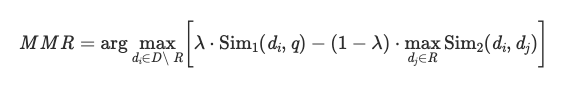

In [ ]:
import numpy as np
# Function to perform Maximal Marginal Relevance (MMR) for diverse retrieval
def mmr(doc_embeddings, query_embedding, lambda_param=0.7, k=5):
    """Maximal Marginal Relevance for diverse retrieval."""
    selected = [] # List to store indices of selected documents
    unselected = list(range(len(doc_embeddings))) # List of indices of unselected documents
    # Compute cosine similarity between document embeddings and the query embedding
    sims = np.dot(doc_embeddings, query_embedding)
    # Select the index of the document with the highest initial similarity to the query
    curr = int(np.argmax(sims))
    # Add the index of the most similar document to the selected list
    selected.append(curr)
    # Remove the selected index from the unselected list
    unselected.remove(curr)

    # Continue selecting documents until 'k' documents are selected or there are no more unselected documents
    while len(selected) < k and unselected:
        mmr_scores = [] # List to store MMR scores for unselected documents
        # Calculate MMR score for each unselected document
        for idx in unselected:
            sim_to_query = sims[idx] # Similarity to the original query
            # Find the maximum similarity of the current unselected document to any already selected document
            sim_to_selected = max([np.dot(doc_embeddings[idx], doc_embeddings[j]) for j in selected])
            # Calculate the MMR score using the lambda_param to balance relevance and diversity
            score = lambda_param * sim_to_query - (1 - lambda_param) * sim_to_selected
            # Append the score and the document index as a tuple
            mmr_scores.append((score, idx))
        # Sort the MMR scores in descending order to find the document with the highest MMR score
        mmr_scores.sort(reverse=True)
        # Select the index of the document with the highest MMR score
        selected.append(mmr_scores[0][1])
        # Remove the selected index from the unselected list
        unselected.remove(mmr_scores[0][1])
    return selected # Return the list of indices of the selected documents

In [ ]:
# Function to encode a text query into an embedding vector using the multimodal embedding model
def encode_query_multimodal(query: str):
    """
    Generate embeddings for text query using the appropriate model.
    For image queries (if future extension), handle differently.
    """
    # Use the globally defined embedding_model (CLIP) to encode the text query
    qemb = embedding_model.encode(query)
    # Return the query embedding vector
    return qemb

In [ ]:
# Function to retrieve multimodal documents (text and image-based) using MMR
def retrieve_with_mmr(query, k=4, mmr_k=3, prefer_text=True, text_weight=1.0, image_weight=0.8):
    """
    Retrieve multimodal documents (text + image) using MMR.
    - prefer_text: boosts textual docs in ranking
    - text_weight / image_weight: relative importance
    """
    # Encode the user query into an embedding vector
    qemb = encode_query_multimodal(query)

    # Pull more candidate documents from ChromaDB than the final 'k' needed for MMR diversity
    # Fetch k*8 candidates based on initial similarity
    res = collection.query(
        query_embeddings=[qemb], # The query embedding
        n_results=k * 8, # Number of results to fetch initially
        include=["documents", "metadatas", "embeddings"] # Include document text, metadata, and embeddings in the results
    )
    # Extract the list of document texts from the query results
    docs = res.get("documents", [[]])[0]
    # Extract the list of document IDs
    ids = res.get("ids", [[]])[0]
    # Extract the list of document embeddings and convert to a numpy array
    embeddings = np.array(res.get("embeddings", [[]])[0])
    # Extract the list of document metadatas
    metas = res.get("metadatas", [[]])[0]

    # Check if any embeddings were retrieved
    if len(embeddings) == 0:
        print(" No embeddings found in collection.")
        return [] # Return an empty list if no documents were retrieved

    # Apply modality weighting to the embeddings based on document type (text or image)
    # This can boost the relevance of certain modalities in the similarity calculation
    weights = np.array([
        text_weight if m.get("type") != "image" else image_weight # Assign weight based on 'type' metadata
        for m in metas
    ])
    # Normalize the retrieved embeddings
    norm_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    # Apply the modality weights to the normalized embeddings
    weighted_embeddings = norm_embeddings * weights[:, None]

    # Compute MMR on the weighted embeddings to select a diverse set of documents
    # mmr_k determines the number of diverse documents to select
    selected_idx = mmr(weighted_embeddings, qemb, lambda_param=0.7, k=mmr_k)

    results = [] # Initialize an empty list to store the final retrieved documents
    # Iterate through the indices of the documents selected by MMR
    for idx in selected_idx:
        # Create a dictionary for each selected document with its ID, text, metadata, and calculated similarity
        entry = {
            "id": ids[idx],
            "text": docs[idx],
            "metadata": metas[idx],
            # Calculate the similarity of the weighted embedding to the query embedding
            "similarity": float(np.dot(weighted_embeddings[idx], qemb))
        }
        results.append(entry) # Add the document entry to the results list

    # Sort the final results by similarity score in descending order
    results = sorted(results, key=lambda x: x["similarity"], reverse=True)
    return results # Return the list of retrieved and ranked documents

In [ ]:
# === Sample test ===
# Check if there are items in the ChromaDB collection before attempting retrieval
if collection.count() > 0:
    print("Retrieve sample multimodal docs:")
    # Define a sample query
    query = "who is the CEO of Reynholm Industries"
    # Call the retrieve_with_mmr function to get relevant documents
    # Retrieve up to 6 initial candidates and select 4 diverse results using MMR
    retrieved = retrieve_with_mmr(query, k=6, mmr_k=4)
    # Iterate through the retrieved documents and print their information
    for i, r in enumerate(retrieved):
        # Get the document type from metadata, default to 'text' if not specified
        meta_type = r["metadata"].get("type", "text")
        # Print the document index, type, source URL, and the first 120 characters of the text (with newlines replaced by spaces)
        print(f"{i+1:02d}. [{meta_type}] {r['metadata'].get('source','')}  →  {r['text'][:120].replace('\\n',' ')}")
else:
    # Print a message if the collection is empty and retrieval cannot be performed
    print(" No items indexed yet.")

Retrieve sample multimodal docs:
01. [text] https://theitcrowd.fandom.com/wiki/The%20IT%20Crowd%20Wiki  →  when I first started Reynholm Industries , I had just two things in my possession: a simple dream, and six million pound
02. [text] https://theitcrowd.fandom.com/wiki/Reynholm%20Industries  →  Department [ ] It is unknown what exact function the International Department of Reynholm Industries actually serves, ho
03. [text] https://theitcrowd.fandom.com/wiki/Denholm  →  Redirect to: Denholm Reynholm
04. [text] https://theitcrowd.fandom.com/wiki/Jeremy  →  who was, in fact, the new head of the Hiring and Firing Department, to see which employees were not contributing to Reyn


## 8 — Query decomposition for big queries

https://blog.epsilla.com/advanced-rag-optimization-boosting-answer-quality-on-complex-questions-through-query-decomposition-e9d836eaf0d5

In [ ]:
# Import the pipeline function from the transformers library for using pre-trained models
from transformers import pipeline, set_seed
# Import torch for using CUDA if available
import torch

In [ ]:
# Set the random seed for reproducibility of results
set_seed(42)

In [ ]:
# === Smart model auto-selection ===
# Function to load a suitable model for query decomposition, with fallbacks
def load_decomposer_model():
    try:
        # Prefer an instruction-tuned model (Mistral-7B-Instruct) if a GPU is available
        if torch.cuda.is_available():
            print("Attempting to load instruction-tuned model: mistralai/Mistral-7B-Instruct-v0.2")
            try:
                # Load the Mistral model for text generation
                return pipeline(
                    "text-generation",
                    model="mistralai/Mistral-7B-Instruct-v0.2",
                    device_map="auto", # Automatically select device (GPU)
                    torch_dtype=torch.bfloat16, # Use bfloat16 for potentially lower memory usage
                    max_new_tokens=256 # Limit the maximum number of new tokens generated
                )
            except (RuntimeError, torch.cuda.OutOfMemoryError) as e:
                # If loading the large model fails (e.g., out of memory), print a warning and fall back
                print(f" Loading large model failed: {e}. Falling back to compact model.")
                # Fallback to a smaller text-to-text model (FLAN-T5 Base)
                return pipeline(
                    "text2text-generation", # Task type for FLAN-T5
                    model="google/flan-t5-base",
                    max_new_tokens=128 # Limit generation length
                )
        else:
            # If no GPU is available, use the smaller text-to-text model (FLAN-T5 Base)
            print(" Using compact model: google/flan-t5-base")
            return pipeline(
                "text2text-generation",
                model="google/flan-t5-base",
                max_new_tokens=128
            )
    except Exception as e:
        # If any other exception occurs during model loading, print a warning and fall back to a very small model (OPT-125m)
        print(" Model load failed, falling back to facebook/opt-125m. Error:", e)
        return pipeline(
            "text-generation",
            model="facebook/opt-125m",
            max_length=256, # Set maximum length for OPT model
            do_sample=False # Disable sampling for deterministic output
        )

# Load the model for query decomposition using the defined function
decomposer = load_decomposer_model()

Attempting to load instruction-tuned model: mistralai/Mistral-7B-Instruct-v0.2


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
decomposer = load_decomposer_model()

Attempting to load instruction-tuned model: mistralai/Mistral-7B-Instruct-v0.2


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0


In [ ]:
# Function to decompose a complex question into simpler sub-questions using the loaded decomposer model
# This is a revised version of the previous decompose_question function
def decompose_question(question: str):
    """
    Split a complex multimodal question into simple, independent sub-questions that a RAG retriever can handle.
    The model auto-detects if image/text reasoning is needed.
    """
    # Add a condition to only decompose if the question length is greater than 500 characters
    if len(question) <= 200:
        return [question]

    # Define the prompt for the language model to perform query decomposition
    # This prompt instructs the model to act as an expert query planner for a multimodal RAG system
    prompt = f"""
You are an expert query planner for a multimodal RAG system. Your knowledge base is centered around "The It Crowd" TV series, including its characters, episodes, plots, and related imagery.

Task:
Decompose the following complex question into simple, independent sub-questions. Each sub-question should be answerable by searching relevant documents or analyzing images from "The It Crowd" context.

Question:
{question}

Guidelines:
- Focus on elements relevant to "The It Crowd" (e.g., characters like Roy, Moss, Jen; episode plots; specific IT scenarios; recurring jokes; visual cues from images).
- Keep each sub-question concise and factual.
- If visual analysis is clearly needed (e.g., "what is shown in the image", "describe the scene in the picture"), include the "image:" prefix.
- Number each sub-question clearly.
- Generate between 3 to 4 distinct sub-questions.

Sub-questions:
""".strip() # Use strip() to remove leading/trailing whitespace from the prompt

    # Run model inference to generate sub-questions
    if "text2text-generation" in decomposer.task:
        # If using a text-to-text model (like FLAN-T5), call the pipeline with the prompt and max tokens
        output = decomposer(prompt, max_new_tokens=128)[0]["generated_text"]
    else:
        # If using a text generation model (like Mistral or OPT), call the the pipeline
        output = decomposer(prompt, max_new_tokens=256)[0]["generated_text"]

    # Postprocess the model output
    # Remove the original prompt from the output
    output = output.replace(prompt, "").strip()
    lines = [] # Initialize a list to store processed sub-question lines
    # Split the output into lines and clean each line
    for line in output.split("\n"):
        # Remove numbering, bullet points, and leading/trailing whitespace from the line
        line = line.strip("-•1234567890. ").strip()
        # If the cleaned line is not empty, add it to the list
        if line:
            lines.append(line)

    # Deduplicate the lines and limit the number of sub-questions
    unique_lines = []
    for l in lines:
        if l not in unique_lines:
            unique_lines.append(l)

    # If no unique lines were generated, return the original question as a single item in a list
    if not unique_lines:
        return [question]

    # Return the unique sub-questions, limited to the first 6 (Note: The prompt asks for 3-4, but the code limits to 6. This can be adjusted.)
    return unique_lines[:6]

In [ ]:
# === Demo ===
# Define a test question to demonstrate query decomposition
test_q = "What is your opinion about Reynholm Industries IT department.What are their expertiese and do they have AI knowledge? Will you hire them for their company?"
test_q_2 = "In \"The IT Crowd,\" analyze how Roy Trenneman's character arc evolves from lazy tech support in season 1 to more confident in later seasons, including key episodes like \"The Work Outing\" and \"The Haunting of Bill Crouse.\" Compare his dynamic with Moss and Jen, citing specific quotes and visual elements from Fandom images such as his messy hair and t-shirts in basement scenes, and discuss how it satirizes IT stereotypes"
# Call the decompose_question function to split the test question into sub-questions
subs = decompose_question(test_q)
# Print the decomposed sub-questions
# Iterate through the sub-questions and print them with numbering
for i, sq in enumerate(subs, 1):
    print(f"{i}. {sq}")

print("Decomposed Sub-Questions:")

# Call the decompose_question function to split the test question into sub-questions
subs = decompose_question(test_q_2)
# Print the decomposed sub-questions
print("Decomposed Sub-Questions:")
# Iterate through the sub-questions and print them with numbering
for i, sq in enumerate(subs, 1):
    print(f"{i}. {sq}")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


1. What is your opinion about Reynholm Industries IT department.What are their expertiese and do they have AI knowledge? Will you hire them for their company?
Decomposed Sub-Questions:
Decomposed Sub-Questions:
1. Describe Roy Trenneman's appearance and habits in the basement in season 1, as depicted in "The IT Crowd" images
2. In which episode does Roy first demonstrate confidence, and what specific actions does he take?
3. How does Roy's confidence change over later seasons, as evidenced by quotes from the show and Fandom images?
4. Compare Roy's character development with those of Moss and Jen, discussing any parallels or contrasts in their confidence levels and IT competence. (image: Roy, Moss, Jen)
5. These sub-questions can be used as a foundation for further research, allowing for a more detailed and accurate response to the original question


## 9 — Synthesize answers for sub-questions and combine

In [ ]:
# Import the pipeline function from the transformers library (aliased as hf_pipeline to avoid name conflict if needed)
from transformers import pipeline as hf_pipeline, set_seed
# Import torch for using CUDA if available
import torch

In [ ]:
# Set the random seed for reproducibility of results
set_seed(42)

In [ ]:
# === Load model with auto-fallback ===
# Function to load a suitable model for synthesizing answers, with fallbacks
def load_synth_model():
    try:
        # Prefer an instruction-tuned model (Mistral-7B-Instruct) if a GPU is available
        if torch.cuda.is_available():
            print("Using instruct model: mistralai/Mistral-7B-Instruct-v0.2")
            # Load the Mistral model for text generation (used for synthesis)
            return hf_pipeline(
                "text-generation",
                model="mistralai/Mistral-7B-Instruct-v0.2",
                device_map="auto", # Automatically select device (GPU)
                torch_dtype=torch.bfloat16, # Use bfloat16 for potentially lower memory usage
                max_new_tokens=512, # Allow for longer generated answers
                temperature=0.3, # Set a low temperature for less creative, more factual generation
                do_sample=True # Enable sampling (though low temperature makes it less random)
            )
        else:
            # If no GPU is available, use the smaller text-to-text model (FLAN-T5 Base) as a fallback
            print("Using fallback: google/flan-t5-base")
            return hf_pipeline(
                "text2text-generation", # Task type for FLAN-T5
                model="google/flan-t5-base",
                max_new_tokens=256 # Limit generation length
            )
    except Exception as e:
        # If any other exception occurs during model loading, print a warning and fall back to GPT-2
        print("Fallback to GPT-2. Error:", e)
        return hf_pipeline(
            "text-generation",
            model="gpt2",
            max_length=256, # Set maximum length for GPT-2
            do_sample=True # Enable sampling for GPT-2
        )

# Load the model for answer synthesis using the defined function
synth = load_synth_model()

Using instruct model: mistralai/Mistral-7B-Instruct-v0.2


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0


In [ ]:
# === Synthesis function ===
# Function to synthesize an answer to a question based on provided context documents
def synthesize_answer(question, contexts):
    """
    Generate an answer using the retrieved multimodal context.
    - Text chunks and image captions are included.
    - Sources are cited inline.
    """
    # If no context documents are provided, return a message indicating this
    if not contexts:
        return "No context retrieved."

    # Build a single string containing all context information
    text_contexts = [] # Initialize a list to store formatted context snippets
    for c in contexts:
        # Get the source URL from the metadata, default to '?' if not found
        source = c["metadata"].get("source", "?")
        # Get the document type (text or image) from metadata, default to 'text'
        dtype = c["metadata"].get("type", "text")
        # Determine the prefix based on the document type for clarity
        prefix = "📄 Text" if dtype == "text" else "🖼️ Image"
        # Get the text content, remove leading/trailing whitespace, and replace newlines with spaces
        snippet = c["text"].strip().replace("\n", " ")
        # Format the context snippet with prefix, source, and text
        text_contexts.append(f"{prefix} ({source}): {snippet}")

    # Join all formatted context snippets into a single string, separated by double newlines
    context_text = "\n\n".join(text_contexts)

    # Define the prompt for the language model to synthesize the answer
    # This prompt instructs the model to act as a multimodal RAG assistant and answer based *strictly* on the context
    prompt = f"""
You are an expert multimodal assistant specialized in the British sitcom 'The IT Crowd', with advanced Retrieval-Augmented Generation (RAG) capabilities drawing from the show's Fandom wiki.

Your task is to generate an accurate and concise answer based on the retrieved `Context` provided below, which consists of data from 'The IT Crowd' episodes, characters, plots, and related visuals.

Guidelines:
- Use the retrieved context as the primary source of truth, focusing on details like episode plots, character traits, quotes, and British humor elements from the show.
- If visual data (e.g., character images, episode screenshots, or memes from the sitcom) are included, describe their relevance briefly in the context of 'The IT Crowd' scenes or themes.
- Cite all supporting evidence from the context explicitly (e.g., “(Source: filename.pdf, page X)” or reference specific episode/character if mentioned).
- If the answer cannot be found in the context, clearly state: "The context from 'The IT Crowd' Fandom wiki does not provide enough information to answer this question."
- Avoid speculation, assumptions, or hallucinations—stick to factual details from the sitcom's canon.
- Keep the answer focused and under 5 sentences unless additional detail is necessary for accuracy, incorporating the show's comedic style where appropriate without adding external info.

---
Context:
{context_text}

Question:
{question}

Answer:
""".strip() # Use strip() to remove leading/trailing whitespace from the prompt

    # Run model inference to generate the answer
    if "text2text-generation" in synth.task:
        # If using a text-to-text model (like FLAN-T5), call the pipeline with the prompt
        output = synth(prompt)[0]["generated_text"]
    else:
        # If using a text generation model (like Mistral or OPT), call the pipeline with parameters
        output = synth(prompt, max_new_tokens=400, temperature=0.3)[0]["generated_text"]

    # Postprocess the model output by removing the original prompt
    answer = output.replace(prompt, "").strip()
    return answer # Return the synthesized answer

In [ ]:
# === Orchestration: Decompose → Retrieve → Synthesize ===
# Function to handle the entire RAG process for a complex question
def answer_with_decomposition(complex_question):
    print(f"\n Processing complex question:\n{complex_question}\n")
    # Decompose the complex question into sub-questions
    subs = decompose_question(complex_question)
    answers = [] # Initialize a list to store results for each sub-question

    # Process each sub-question
    for s in subs:
        print(f" Retrieving for sub-question: {s}")
        # Retrieve relevant context documents for the current sub-question using MMR
        # k=8 means fetch up to 8 initial candidates, mmr_k=4 means select up to 4 diverse results
        ctxs = retrieve_with_mmr(s, k=8, mmr_k=4)
        # Synthesize an answer for the sub-question based on the retrieved context
        ans = synthesize_answer(s, ctxs)
        # Append the sub-question, its answer, and the retrieved contexts to the answers list
        answers.append({"subquestion": s, "answer": ans, "contexts": ctxs})

    # Combine the answers to the sub-questions into a unified summary
    # Create a list of the synthesized answers from each sub-question
    combined_contexts = [a["answer"] for a in answers]
    # Define the prompt for the language model to summarize the sub-answers
    # This prompt instructs the model to act as an expert summarizer and combine the sub-answers
    summary_prompt = f"""
You are an expert summarizer specialized in the British sitcom 'The IT Crowd', for a multimodal Retrieval-Augmented Generation (RAG) system drawing from the show's Fandom wiki.

Your task is to synthesize the following sub-answers into one clear, concise, and well-structured final explanation, focusing on integrating details from episodes, characters, plots, quotes, and British humor elements.

Guidelines:
- Integrate information from both text and visual reasoning when applicable, such as describing scene screenshots or character images in the context of 'The IT Crowd' themes or comedic moments.
- Preserve key factual details, attributions, and episode-specific references from the sub-answers (e.g., cite episodes or characters explicitly if mentioned).
- Eliminate redundancy and contradictions while maintaining the show's witty and satirical tone where it fits naturally.
- Maintain logical flow and clarity, structuring the summary around the sitcom's narrative or character arcs.
- Keep the final summary concise (around 4-5 sentences) unless additional detail is necessary for accuracy.
- Do NOT add new information beyond what appears in the sub-answers—stick to the 'The IT Crowd' canon.

Sub-answers:
{chr(10).join(combined_contexts)} # Join the sub-answers with newline characters

Final summarized answer:
""".strip() # Use strip() to remove leading/trailing whitespace from the prompt


    # Run model inference to generate the summarized answer
    if "text2text-generation" in synth.task:
        # If using a text-to-text model, call the pipeline with the summary prompt
        summary = synth(summary_prompt)[0]["generated_text"]
    else:
        # If using a text generation model, call the pipeline with parameters
        summary = synth(summary_prompt, max_new_tokens=400, temperature=0.3)[0]["generated_text"]

    # Postprocess the model output by removing the original summary prompt
    summary = summary.replace(summary_prompt, "").strip()
    # Return a dictionary containing the sub-answers and the combined summary
    return {"subanswers": answers, "combined": summary}

In [ ]:
# === Test Run ===
# Define a complex question to test the answer_with_decomposition function
test_question = " why the IT department always ask can you to try turn on and off your computer?"
# Call the function to get the decomposed sub-questions, individual answers, and the final summarized answer
res = answer_with_decomposition(test_question)

# Print the final combined answer
print("\n Final Combined Answer:\n")
# Print the first 1200 characters of the combined answer
print(res["combined"][:1200])





Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



 Processing complex question:
 why the IT department always ask can you to try turn on and off your computer?

 Retrieving for sub-question:  why the IT department always ask can you to try turn on and off your computer?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



 Final Combined Answer:

The IT department in 'The IT Crowd' is known for their humorous approach to troubleshooting, often suggesting users to try turning on and off their computers as a simple yet effective solution to various issues. This practice, which stems from their extensive experience and the belief that many problems can be resolved by restarting the system, was possibly popularized by Denholm Reynholm, the eccentric CEO of Reynholm Industries, who famously believed his computer could be controlled by voice commands (episode: "The Voice of God"). Jen Barber, a dedicated member of the IT team, also relies on this method despite her limited computer knowledge, demonstrating their shared determination to solve problems and keep the company running.


In [ ]:
test_question_complex="Explore the character development of Maurice Moss, portrayed by Richard Ayoade, in \"The IT Crowd,\" detailing his quirky personality traits such as his extreme literal-mindedness, social ineptitude, and encyclopedic knowledge of obscure facts, which often lead to hilarious situations like in the episode \"Calamity Jen\" where he accidentally sets off the fire alarm or in \"Are We Not Men?\" where he tries to fit in with football fans. How does Moss's relationship with Roy evolve from mere colleagues to a bromance filled with mutual dependence, as seen in episodes like \"The Haunting of Bill Crouse\ where they collaborate on pranks? Furthermore, analyze how Moss represents neurodiversity in comedy, potentially drawing parallels to real-world discussions on autism spectrum representation in media, but strictly based on show content without speculation. Include quotes from memorable lines, such as his famous \"I came here to drink milk and kick ass, and I've just finished my milk,\" and discuss how visual elements like his oversized glasses and afro hairstyle contribute to his iconic look. Lastly, contrast Moss with Jen Barber, the IT manager who knows nothing about computers, and explain how their dynamic drives much of the show's conflict and resolution in various plotlines across the series"

# Call the function to get the decomposed sub-questions, individual answers, and the final summarized answer
res = answer_with_decomposition(test_question_complex)

# Print the final combined answer
print("\n Final Combined Answer:\n")
# Print the first 1200 characters of the combined answer
print(res["combined"][:1200])


<>:1: SyntaxWarning: invalid escape sequence '\ '
<>:1: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-1393307527.py:1: SyntaxWarning: invalid escape sequence '\ '
  test_question_complex="Explore the character development of Maurice Moss, portrayed by Richard Ayoade, in \"The IT Crowd,\" detailing his quirky personality traits such as his extreme literal-mindedness, social ineptitude, and encyclopedic knowledge of obscure facts, which often lead to hilarious situations like in the episode \"Calamity Jen\" where he accidentally sets off the fire alarm or in \"Are We Not Men?\" where he tries to fit in with football fans. How does Moss's relationship with Roy evolve from mere colleagues to a bromance filled with mutual dependence, as seen in episodes like \"The Haunting of Bill Crouse\ where they collaborate on pranks? Furthermore, analyze how Moss represents neurodiversity in comedy, potentially drawing parallels to real-world discussions on autism spectrum representati


 Processing complex question:
Explore the character development of Maurice Moss, portrayed by Richard Ayoade, in "The IT Crowd," detailing his quirky personality traits such as his extreme literal-mindedness, social ineptitude, and encyclopedic knowledge of obscure facts, which often lead to hilarious situations like in the episode "Calamity Jen" where he accidentally sets off the fire alarm or in "Are We Not Men?" where he tries to fit in with football fans. How does Moss's relationship with Roy evolve from mere colleagues to a bromance filled with mutual dependence, as seen in episodes like "The Haunting of Bill Crouse\ where they collaborate on pranks? Furthermore, analyze how Moss represents neurodiversity in comedy, potentially drawing parallels to real-world discussions on autism spectrum representation in media, but strictly based on show content without speculation. Include quotes from memorable lines, such as his famous "I came here to drink milk and kick ass, and I've just f

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Retrieving for sub-question: What are some key personality traits of Maurice Moss, as displayed in "The It Crowd," such as literal-mindedness, social ineptitude, and extensive knowledge of obscure facts? Provide examples from specific episodes like "Calamity Jen" and "Are We Not Men?"


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Retrieving for sub-question: How does the relationship between Maurice Moss and Roy Trenneman evolve in "The It Crowd" from colleagues to a bromance, as seen in episodes like "The Haunting of Bill Crouse"? Share quotes from memorable lines that illustrate their bond


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Retrieving for sub-question: In what ways does Maurice Moss's portrayal in "The It Crowd" reflect neurodiversity in comedy? Describe any visual elements, such as his oversized glasses and afro hairstyle, that contribute to his iconic look


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Retrieving for sub-question: Compare and contrast the dynamic between Maurice Moss and Jen Barber in "The It Crowd," focusing on how their contrasting roles and knowledge levels contribute to the show's conflict and resolution in various plotlines across the series


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



 Final Combined Answer:

Maurice Moss, portrayed by Richard Ayoade, is a socially awkward, neurodivergent IT specialist in 'The IT Crowd'. Known for his extensive knowledge of obscure facts and fixation on technology, Moss's character explores themes of social isolation and communication difficulties. His contrasting relationship with Jen Barber, a socially adept manager, creates comedic tension and resolution throughout the series. In episodes like "Calamity Jen" and "The Haunting of Bill Crouse," Moss's literal-mindedness and friendship with Roy Trenneman are showcased, while their contrasting roles and misunderstandings highlight the importance of clear communication in their working relationship.


## 10 — Gradio demo (Decompose → Retrieve → Synthesize)

Gradio - https://www.gradio.app/docs

In [ ]:
# Import the gradio library for building the web UI
import gradio as gr
# Import the Image class from PIL for image handling
from PIL import Image
# Import the os module for interacting with the operating system (used for file paths)
import os

In [ ]:
# Define the main function for the Gradio chat interface
def chat_ui(user_q, user_img):
    """
    Handles text + optional image input for multimodal reasoning.
    """
    # Check if the user provided either a question or an image
    if not user_q and not user_img:
        # If neither is provided, return a warning message and no images
        return "Please enter a question or upload an image.", None

    # Process the uploaded image if one is provided
    extra_contexts = [] # Initialize a list to store extra context from the image
    if user_img:
        # Generate a caption for the uploaded image using the caption_image function (BLIP/CLIP model)
        caption = caption_image(user_img)
        # Add the image caption as an extra context document
        extra_contexts.append({
            "id": "uploaded_image", # Assign a fixed ID for the uploaded image context
            "text": caption, # The generated caption as text
            "metadata": {"source": "user_upload", "type": "image", "path": user_img} # Metadata for the uploaded image
        })
        # Print the generated caption for the uploaded image
        print(f" Uploaded image caption: {caption}")

    # Combine the user's text query and the image caption (if any) for embedding and decomposition
    combined_query = user_q or "" # Start with the user's text query, or an empty string if none
    if extra_contexts:
        # Append the text from extra contexts (image captions) to the combined query
        combined_query += " " + " ".join([c["text"] for c in extra_contexts])

    # Run the complete RAG process: decompose, retrieve, and synthesize
    out = answer_with_decomposition(combined_query)

    # Collect all relevant images to display in the gallery
    retrieved_images = [user_img] if user_img else [] # Include the uploaded image if present

    # Iterate through the results for each sub-question
    for a in out["subanswers"]:
        # Iterate through the context documents retrieved for the sub-question
        for c in a["contexts"]:
            # If the context is an image and has a file path, add it to the list of images to display
            if c["metadata"].get("type") == "image" and "path" in c["metadata"]:
                retrieved_images.append(c["metadata"]["path"])

    # Format the output for the Gradio Markdown component
    # Create a markdown string including each sub-question and its answer
    markdown = "\n\n".join(
        f"###  {i+1}. {a['subquestion']}\n**Answer:** {a['answer']}"
        for i, a in enumerate(out["subanswers"])
    )
    # Append the final combined answer as a separate section
    markdown += f"\n\n---\n###  Combined Answer\n{out['combined']}"

    # Return the formatted markdown text and the list of image paths for the gallery
    return markdown, retrieved_images

Testing 1 - Simple Query: <br>

1. who are all  team members in the  in it department?<br>
2. What is behind the red door?


<br>
https://www.youtube.com/watch?v=ct1-zq8gf_0

Testing 2 - Friend Face

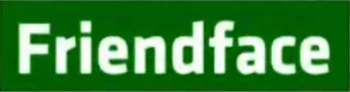

Testing 3 - Bigger query<br>

In \"The IT Crowd,\" analyze how Roy Trenneman's character arc evolves from lazy tech support in season 1 to more confident in later seasons, including key episodes like \"The Work Outing\" and \"The Haunting of Bill Crouse.\" Compare his dynamic with Moss and Jen, citing specific quotes and visual elements from Fandom images such as his messy hair and t-shirts in basement scenes, and discuss how it satirizes IT stereotypes


In [ ]:
# Create a Gradio Interface for the chat UI
demo = gr.Interface(
    fn=chat_ui, # The function to call when the user interacts with the UI
    inputs=[
        gr.Textbox(lines=2, label="Enter your question"), # Textbox input for the user's question
        gr.Image(type="filepath", label="Optional image input") # Image input for optional image upload
    ],
    outputs=[
        gr.Markdown(label="Answer and Sources"), # Markdown output to display the answer and sources
        gr.Gallery(label="Relevant Images", columns=3, height="auto") # Gallery output to display relevant images
    ],
    title="IT Crowd BOT", # Title of the Gradio interface
    description="Upload an image and/or enter a question. The model will retrieve relevant text and images and synthesize an answer.", # Description of the interface
)
# Launch the Gradio interface
# share=True generates a public URL for sharing
# debug=True provides detailed logs in the console
demo.launch(share=True, debug=True)



### Improvements on notebook
- Using a bigger Model
- Using Lanchain pipeline
- Using PDF documents as source
